In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('max_columns', 100)
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Quick Problem Overview

1. Who is our stakeholder? - Booking Manager
2. What is the core business problem we are solving? - Revenue Management. Maximizing Revenue while ensuring no customer dissatisfaction due to incorrect predictions.
3. Convert Business to DS Problem: Determine if a booking will be canceled or not. And what leads to cancellations. 
4. Business Metric: How much Overbookings can we take ( based on reliable cancelation predictions from the model)
5. Data Science Metic: Recall/ Precision/ F1 Score
6. Feature Selection: Done
7. Feature Engineering: Done
8. EDA Questions: Done

# 1. Reading the Data

In [3]:
# Loading the Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hotel_bookings.csv')

In [4]:
df.shape

(119390, 32)

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
# Categorial Features
df.select_dtypes(include = 'object').columns.tolist()

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [7]:
# Numerical Features
df.select_dtypes(include = ['float','int']).columns.tolist()

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

# 2. Dealing with Missing Values

In [8]:
# Percentage of missing values per column (feature)
np.round(df.isna().sum() / len(df) *100, 4)

hotel                              0.0000
is_canceled                        0.0000
lead_time                          0.0000
arrival_date_year                  0.0000
arrival_date_month                 0.0000
arrival_date_week_number           0.0000
arrival_date_day_of_month          0.0000
stays_in_weekend_nights            0.0000
stays_in_week_nights               0.0000
adults                             0.0000
children                           0.0034
babies                             0.0000
meal                               0.0000
country                            0.4087
market_segment                     0.0000
distribution_channel               0.0000
is_repeated_guest                  0.0000
previous_cancellations             0.0000
previous_bookings_not_canceled     0.0000
reserved_room_type                 0.0000
assigned_room_type                 0.0000
booking_changes                    0.0000
deposit_type                       0.0000
agent                             

### We have 4 columns that have missing values - Children, Country, Agent, Company.

Company has 94% of missing values. The remaining 6% of values represent the company IDs that made the booking. NaN is used for booking not made by companies. 

Let's analyse this further.

Mean probability of cancellation for Company made bookings: 0.13341652238311338
Mean probability of cancellation for Overall bookings: 0.37041628277075134


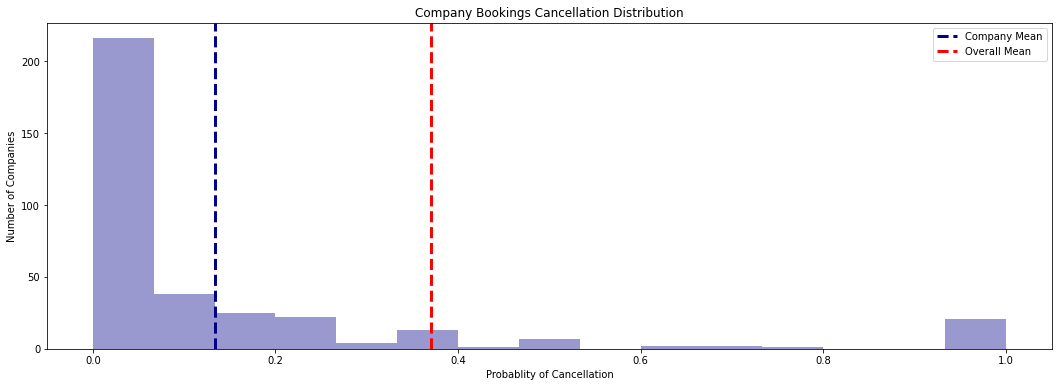

In [9]:
# Should the Company column be dropped?

# Percentage of cancelations done by a company against total booking done by that company
company_bookings = df.groupby('company')['is_canceled'].sum() / df.groupby('company')['is_canceled'].count() 

plt.figure(figsize = (18,6))
sns.distplot(company_bookings, kde = False, color = 'darkblue', bins = 15)
plt.axvline(company_bookings.mean(), color='darkblue', linestyle='dashed', linewidth=3)
print('Mean probability of cancellation for Company made bookings:', company_bookings.mean())
plt.axvline(df.is_canceled.mean(), color = 'r', linestyle='dashed', linewidth=3)
print('Mean probability of cancellation for Overall bookings:', df.is_canceled.mean())
plt.legend(['Company Mean','Overall Mean'])

plt.title('Company Bookings Cancellation Distribution')
plt.xlabel('Probablity of Cancellation')
plt.ylabel('Number of Companies')
plt.show()

### Should the Company Column be dropped?

It seems like the cancellations are significantly less likely to happen if the booking is under a company. By dropping this column we will lose out on crucial information. Instead we will mark all missing values in this column with a 0 - meaning the booking was not company made. And all values that have company IDs present, we will replace those with 1 - meaning the booking was made by a company. 
Let's update the Company Column and look at the Country Column next.

In [10]:
# Updating Company Column

df.company.loc[~df.company.isnull()] = 1
df.company.loc[df.company.isnull()] = 0




A reasonale approach for the country column is to replace all the missing values with the mode value of the column, which is PRT (Portugal). 
However before we do that let's have a look at the Cancellation Distribution Missing Countries against the Mode Country 




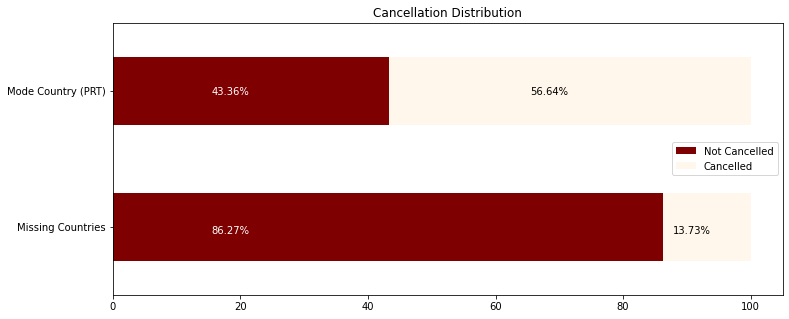

In [11]:
# Plotting the Cancellation Distribution of Missing Countries against the Mode Country 

mode_vs_missing = pd.DataFrame(index = ['Missing Countries', 'Mode Country (PRT)'], columns=['Not Cancelled','Cancelled'])

mode_vs_missing.iloc[0,0] = (df[df.country.isna()].is_canceled.value_counts() / len(df[df.country.isna()]) * 100)[0]
mode_vs_missing.iloc[0,1] = (df[df.country.isna()].is_canceled.value_counts() / len(df[df.country.isna()]) * 100)[1]
mode_vs_missing.iloc[1,0] = (df[df.country == 'PRT'].is_canceled.value_counts() / len(df[df.country == 'PRT']) * 100)[0]
mode_vs_missing.iloc[1,1] = (df[df.country == 'PRT'].is_canceled.value_counts() / len(df[df.country == 'PRT']) * 100)[1]

ax = mode_vs_missing.plot(kind = 'barh', stacked = True, colormap = 'OrRd_r', figsize = (12,5))

ax.text(15.5, 0.97, '{}%'.format(np.round(mode_vs_missing.iloc[1,0], 2)), color = 'white' )
ax.text(65.5, 0.97, '{}%'.format(np.round(mode_vs_missing.iloc[1,1], 2)), color = 'black' )

ax.text(15.5, - 0.05, '{}%'.format(np.round(mode_vs_missing.iloc[0,0], 2)), color = 'white' )
ax.text(87.8, - 0.05, '{}%'.format(np.round(mode_vs_missing.iloc[0,1], 2)), color = 'black' )

plt.title('Cancellation Distribution')
plt.show()

### Should the Country Column be dropped?
As the distributions differ quite significantly,replacing the missing values with the mode (PRT) will have some mis-represented data. We might be better off just dropping the rows corresponding to these 0.4% missing values. 

In [12]:
# Dropping Country Column

df.drop(df[df.country.isna()].index, 0, inplace = True)

In [13]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [14]:
df.shape

(118902, 32)

### We are left with 2 more columns with missing values. 

1. Children: There are just 4 NaN values in this column. We will drop the corresponding rows. 
2. Agent: NaN values in this column means no agent or 3rd party was used for booking. We will resolve this similarly to the Company Column - replace NaNs with 0(agent not used) and all other values with 1(agent used).

Let's do that below.

In [15]:
# Dropping rows corresponding to missing values in 'Children'
df.drop(df[df.children.isna()].index, 0, inplace = True)

# Updating Agent Column
df.agent.loc[~df.agent.isnull()] = 1
df.agent.loc[df.agent.isnull()] = 0

In [16]:
df.shape

(118898, 32)




# 3. Exploratory Data Analysis

### Here are some Questions that would give us more insight into the data we are working with:

1. Where do the guests come from?


2. How much do guests pay for a room per night?


3. How does the price per night vary over the year?


4. Which are the most busy month?


5. How long do people stay at the hotels?


6. Bookings by market segment


7. How does lead time effect cancellations?


### Where do most of the guests come from? (Top 10 Countries)

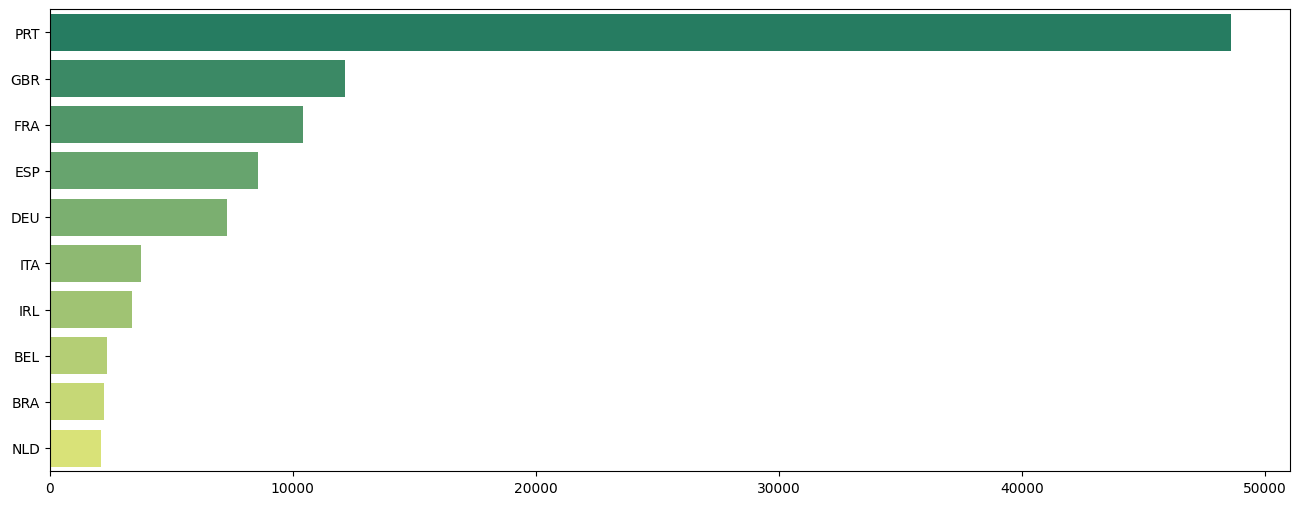

In [23]:
plt.rcdefaults() # styling visualisations

plt.figure(figsize = (16,6))
sns.barplot(x = df.country.value_counts()[:10].values,
            y = df.country.value_counts()[:10].index, palette = 'summer' )

plt.show()

Most guests come from the home country - Portugal itself. Infact with the exception of Brazil, all top countries are in close proximity i.e. Western Europe. 

### How much do guests pay for a room per night? 

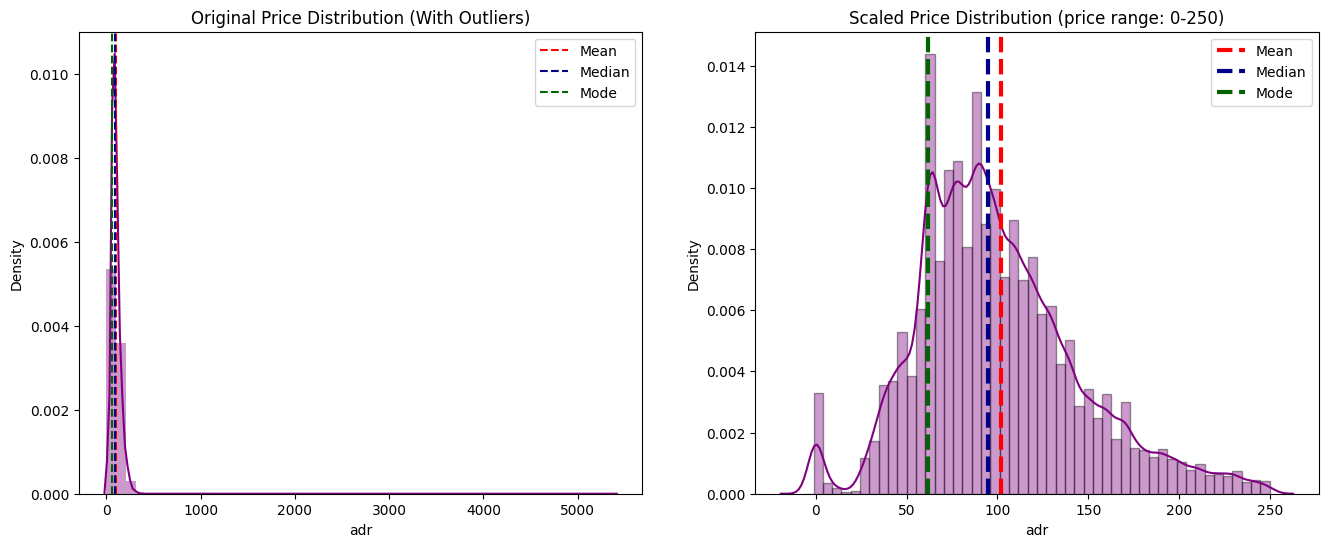

Prices with Outliers: 

Mean value is:102.00324252720587
Median value is:95.0
Mode value is:62.0 
 

Prices without Outliers: 

Mean value is:100.04554795335231
Median value is:94.5
Mode value is:62.0


In [24]:
plt.rcdefaults()

fig, ax = plt.subplots(1,2,figsize = (16,6)) # creating subplots

# Price Distribution with Outliers
orgininal_price_distribution = sns.distplot(df.adr, ax = ax[0], color = 'purple')
ax[0].axvline(df.adr.mean(), color = 'r', label = 'Mean',linestyle='dashed')
ax[0].legend()
ax[0].axvline(df.adr.median(), color = 'darkblue', label = 'Median',linestyle='dashed')
ax[0].legend()
ax[0].axvline(df.adr.mode()[0], color = 'darkgreen', label = 'Mode',linestyle='dashed')
ax[0].legend()
ax[0].set_title('Original Price Distribution (With Outliers)')


# Price Distribution without Outliers
scaled_price_distribution = sns.distplot(df[df.adr <= 250].adr, ax = ax[1],
                                         color = 'purple', hist_kws=dict(edgecolor="k", linewidth=1, alpha = 0.4))
ax[1].axvline(df.adr.mean(), color = 'r', lw = 3 ,label = 'Mean',linestyle='dashed')
ax[1].legend()
ax[1].axvline(df.adr.median(), color = 'darkblue', lw = 3, label = 'Median',linestyle='dashed')
ax[1].legend()
ax[1].axvline(df.adr.mode()[0], color = 'darkgreen', lw = 3, label = 'Mode',linestyle='dashed')
ax[1].legend()
ax[1].set_title('Scaled Price Distribution (price range: 0-250)')

plt.show()

print('Prices with Outliers: \n')
print('Mean value is:{}'.format(df.adr.mean()))
print('Median value is:{}'.format(df.adr.median()))
print('Mode value is:{} \n \n'.format(df.adr.mode()[0]))

print('Prices without Outliers: \n')
print('Mean value is:{}'.format(df[df.adr <= 250].adr.mean()))
print('Median value is:{}'.format(df[df.adr <= 250].adr.median()))
print('Mode value is:{}'.format(df[df.adr <= 250].adr.mode()[0]))

### How does the price per night vary over the year?  Which are the most busy months?

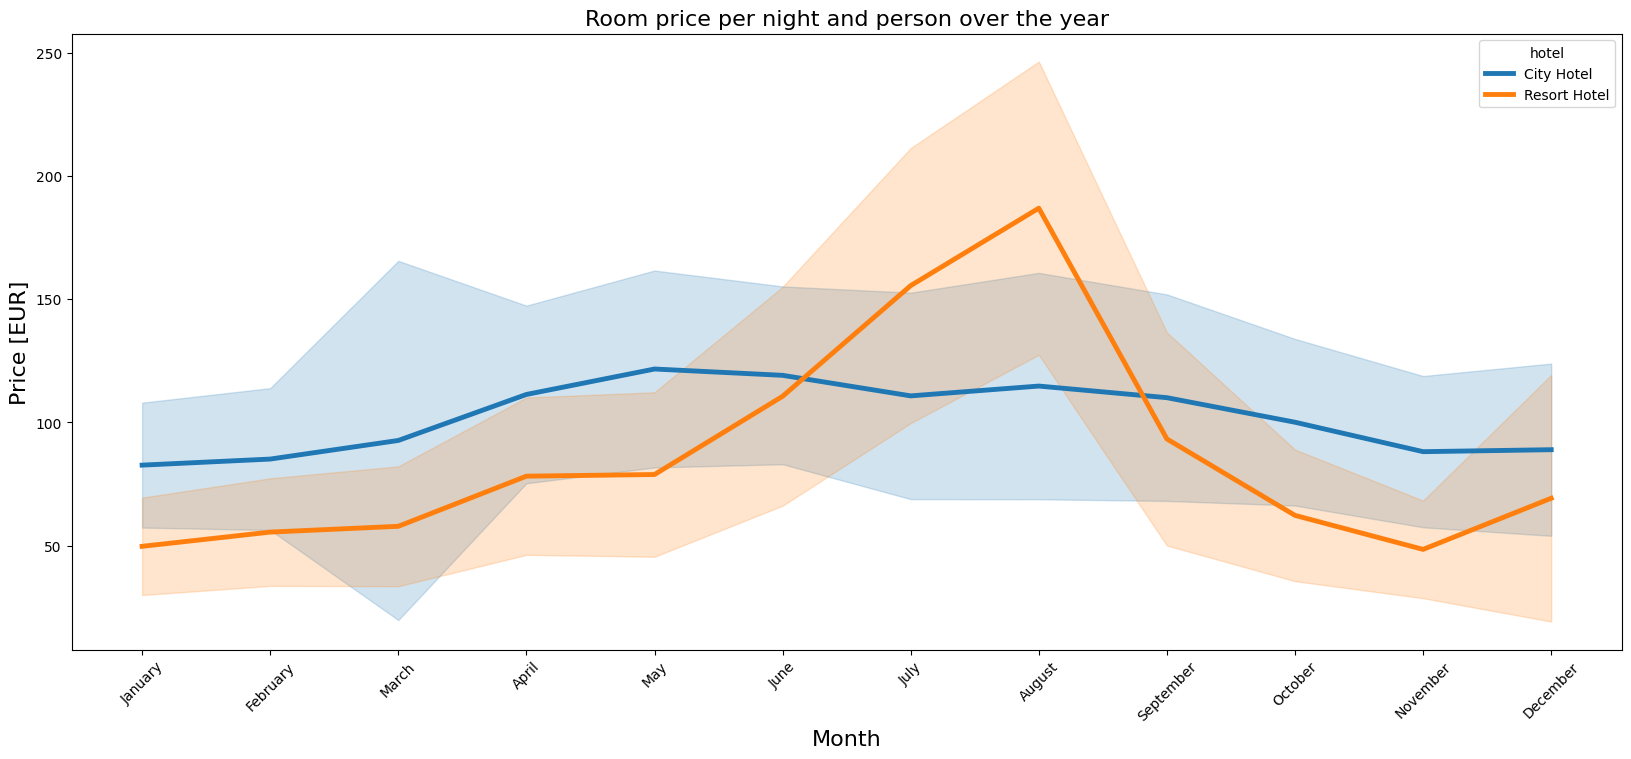

In [ ]:
# grab data:
room_prices_monthly = df[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(20, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=room_prices_monthly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(3.5, 3.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

Resort Hotel has a huge influx of guests over the summer, since people tend to travel for leisure and vacation more during this time. On the contrary the City Hotel has a comparatively uniform distribution of travellers throughout the year. Being in the city of Lisbon and used by people travelling for business could be one of the reasons for that. 

### How long do people stay at these hotels?

Average nights stayed in the Resort Hotel: 4.34
Average nights stayed in the City Hotel: 2.98


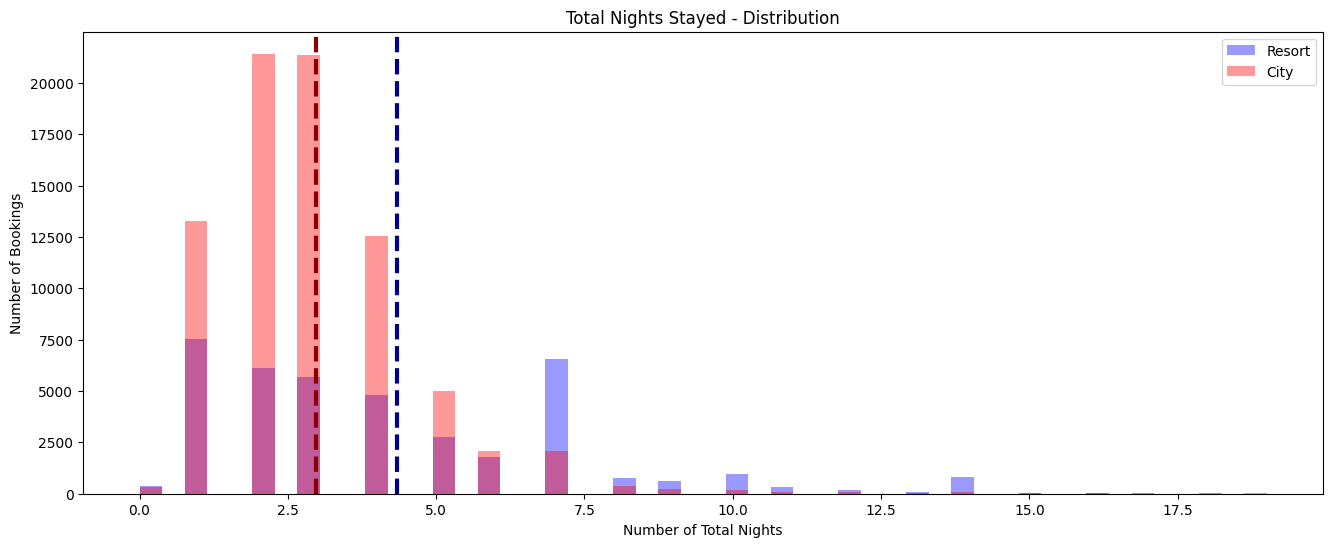

In [26]:
# creating a seperate dataframe
stay_duration = df[['stays_in_weekend_nights','stays_in_week_nights']]
stay_duration['total_nights'] = stay_duration.sum(axis = 1) # adding week and weekend night to get total nights
stay_duration['hotel'] = df.hotel

plt.figure(figsize = (16,6))

resort_stay = sns.distplot(stay_duration[stay_duration.hotel == 'Resort Hotel'][stay_duration.total_nights < 20] \
             .total_nights,kde = False, label = 'Resort', color = 'blue')
resort_stay.axvline(stay_duration[stay_duration.hotel == 'Resort Hotel'].total_nights.mean(),
                    color = 'darkblue', lw = 3, linestyle='dashed')
resort_stay.legend()


hotel_stay = sns.distplot(stay_duration[stay_duration.hotel == 'City Hotel'][stay_duration.total_nights < 20] \
             .total_nights,kde = False, label = 'City', color = 'red')
hotel_stay.axvline(stay_duration[stay_duration.hotel == 'City Hotel'].total_nights.mean(),
                   color = 'darkred', lw = 3, linestyle='dashed')
hotel_stay.legend()

print('Average nights stayed in the Resort Hotel: {}'.format(np.round(stay_duration[stay_duration.hotel == 'Resort Hotel'].total_nights.mean(),2)))
print('Average nights stayed in the City Hotel: {}'.format(np.round(stay_duration[stay_duration.hotel == 'City Hotel'].total_nights.mean(),2)))

plt.xlabel('Number of Total Nights')
plt.ylabel('Number of Bookings')
plt.title('Total Nights Stayed - Distribution')
plt.show()

### Bookings by market segment

Total Bookings in City Hotel: 79302
Total Bookings in City Hotel: 39596


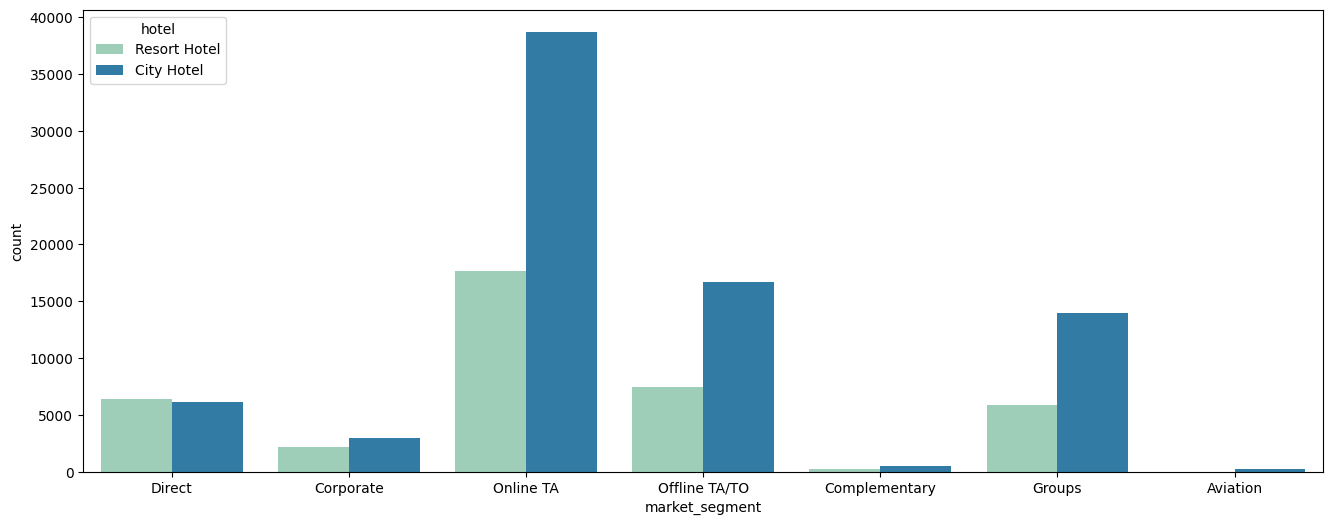

In [ ]:
plt.figure(figsize = (16,6))
sns.countplot(df.market_segment, data = df, hue = 'hotel', palette = 'YlGnBu')

print('Total Bookings in City Hotel: {}'.format(df.hotel.value_counts()[0]))
print('Total Bookings in City Hotel: {}'.format(df.hotel.value_counts()[1]))

plt.show()

### How does lead time effect cancellations?

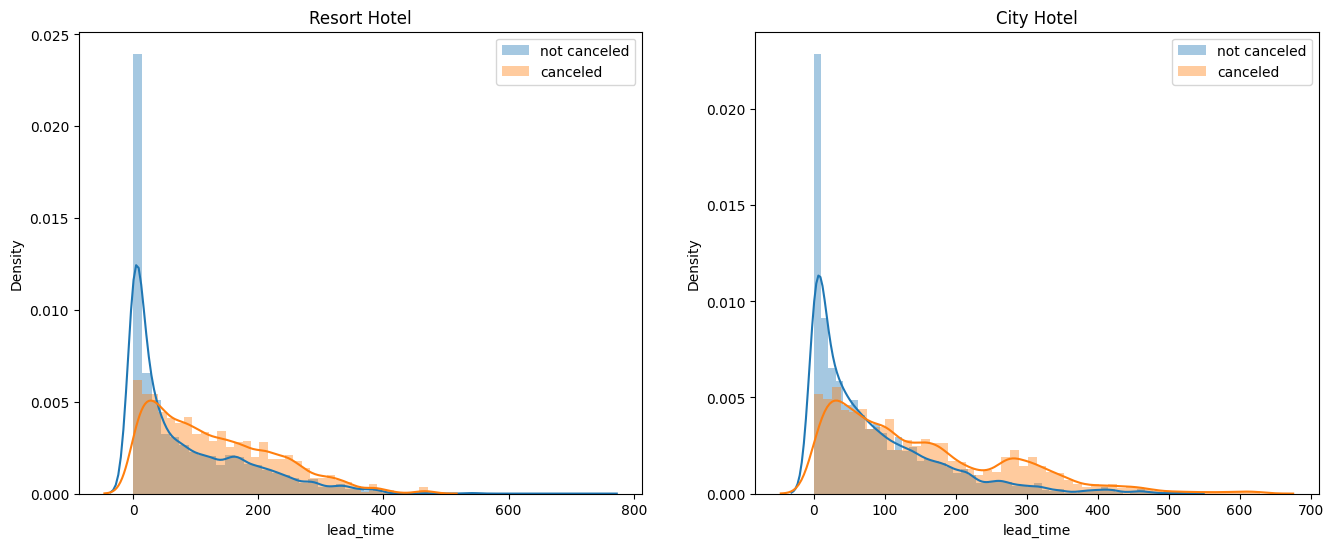

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,6))

sns.distplot(df[df.hotel == 'Resort Hotel'][df.is_canceled == 0].lead_time,
                                    label = 'not canceled', ax = ax[0])
sns.distplot(df[df.hotel == 'Resort Hotel'][df.is_canceled == 1].lead_time,
                                 label = 'canceled', ax = ax[0])
ax[0].set_title('Resort Hotel')
ax[0].legend()


sns.distplot(df[df.hotel == 'City Hotel'][df.is_canceled == 0].lead_time,
                                    label = 'not canceled', ax = ax[1])
sns.distplot(df[df.hotel == 'City Hotel'][df.is_canceled == 1].lead_time,
                                 label = 'canceled', ax = ax[1])
ax[1].set_title('City Hotel')
ax[1].legend()

plt.show()

### Lead Time: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

In both the cases - Resort Hotel and City Hotel - the distribution of cancelled bookings seems to be more spread out and flat. From here we could infer that the longer the lead time the more likely is the booking to be cancelled. 

# 4. Feature Engineering

### Numerical Features

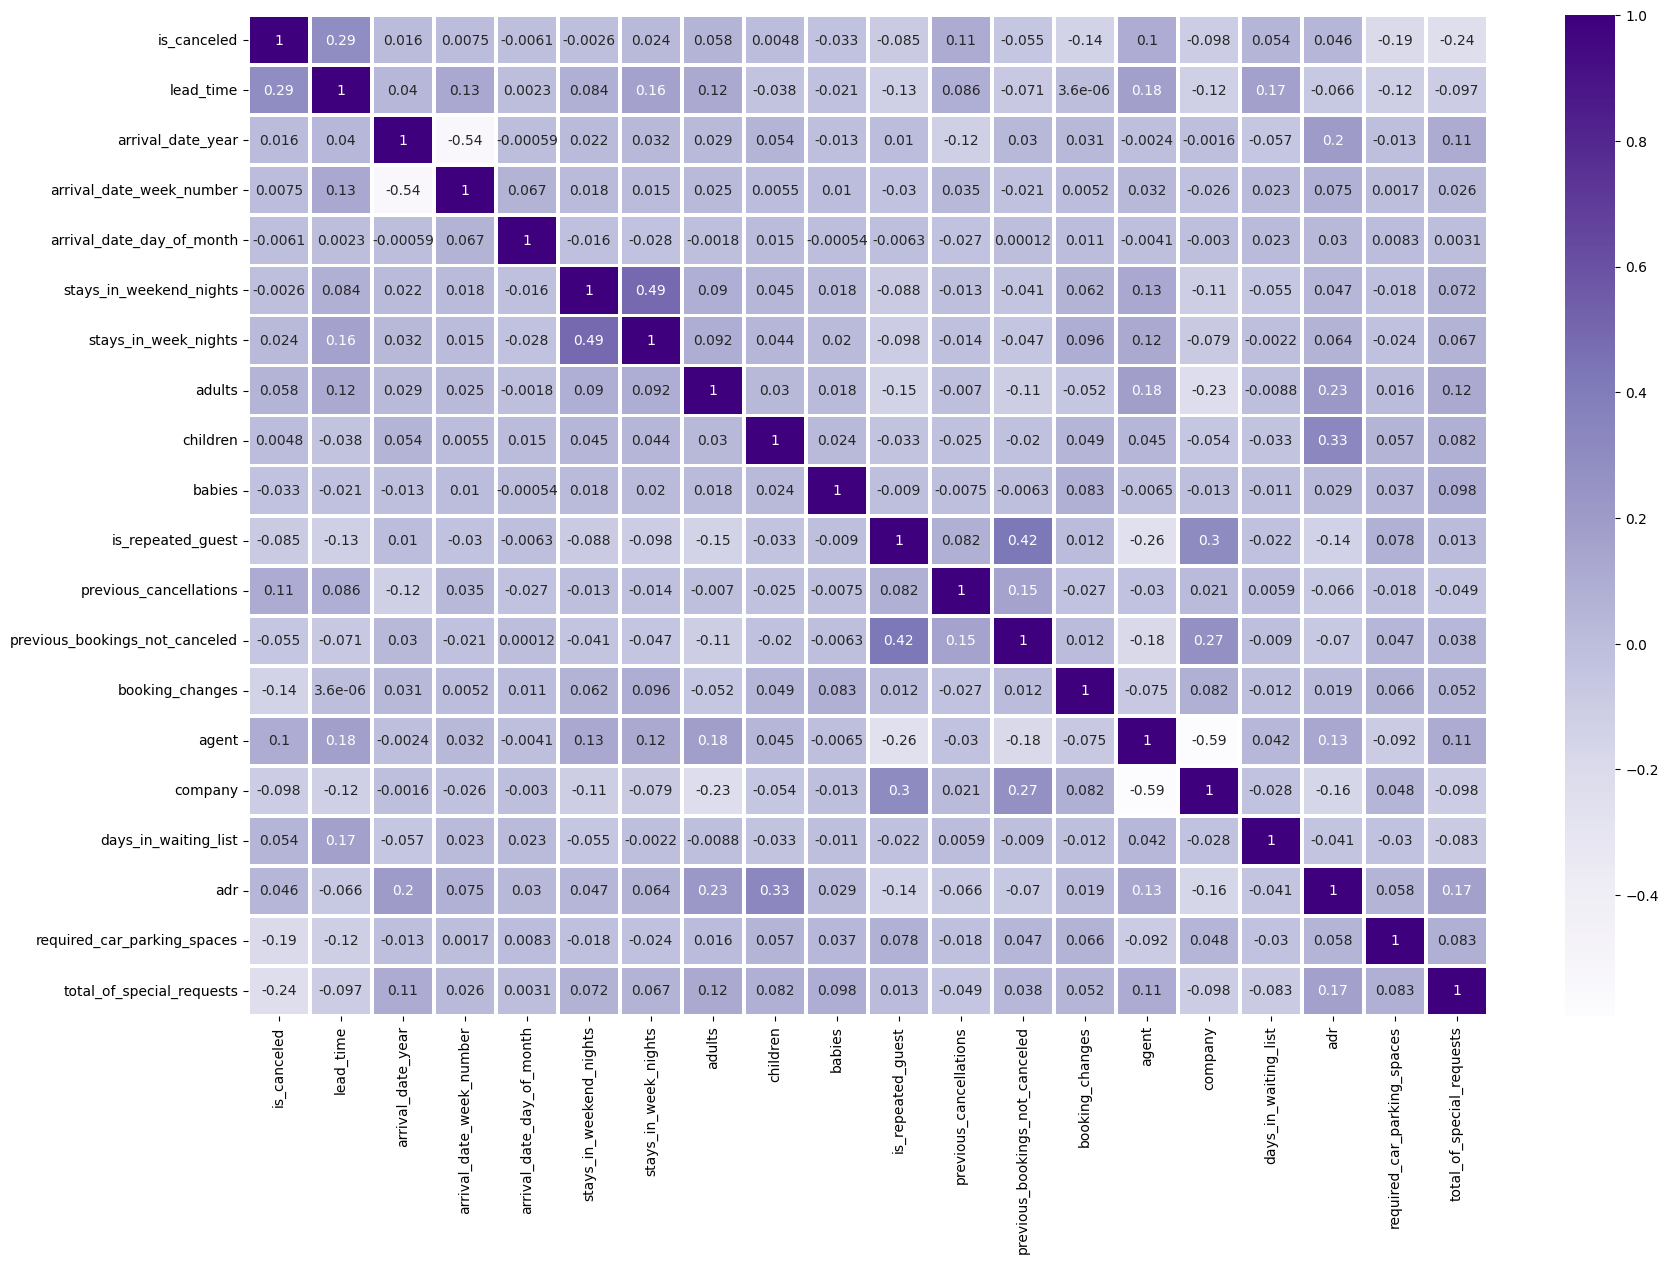

In [ ]:
plt.figure(figsize = (20,13))
sns.heatmap(df.corr(), cmap = 'Purples', lw = 2, annot = True)

### Categorical Features

In [ ]:
df[['reservation_status','reservation_status_date','is_canceled']].head()

,reservation_status,reservation_status_date,is_canceled
0,Check-Out,2015-07-01,0
1,Check-Out,2015-07-01,0
2,Check-Out,2015-07-02,0
3,Check-Out,2015-07-02,0
4,Check-Out,2015-07-03,0


#### If we look at the feature description from the dataset:

1. **Reservation Status:** Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out - customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why.
2. **Reservation Status Date:** Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel.


Data on these 2 features is collected only after the expected date of arrival has been past. Values in these features are a direct result if the booking was cancelled on not. 
In other words, this information is a lag parameter - it lags our target variable. 

#### It will be incorrect to include these 2 features for 2 reasons:
1. We won't have this data while trying to make a prediction on the possibility of a cancellation. 
2. Reservation Status even if collected later, is just another way of representing cancellations.

#### Let's go ahead and drop these columns!

In [ ]:
# Making a copy of the main DataFrame. Will be using the copied version from here on.
data = df.copy()

In [ ]:
# Categorical Columns to drop 
cal_columns = ['reservation_status_date', 'reservation_status']

In [ ]:
data.drop(cal_columns, 1, inplace = True)

### Categorical Column - Country

There are several countries (categories) in the column. We will keep the top 10 countries and replace all other country values by 'Others'. This is allow us to capture most of the data, while keeping our total number of features less while one-hot encoding - as majority of the bookings come from these top 10 countries

In [ ]:
top_10 = data.country.value_counts()[:10].index.tolist()
others = data.country.value_counts()[10:].index.tolist()
data.loc[:,'country'] = data.country.apply(lambda x: 'Others' if x in others else x )

In [ ]:
data.shape

(118898, 30)

In [ ]:
data.select_dtypes('object').head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient


### Categorical Column - Hotel

There are only 2 categories for this feature - Resort Hotel and City Hotel.
So we will apply a simple Label Encoder. This feature doesn't need to be one-hot encoded.

In [ ]:
# Encoding 'Hotel' Column

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data.loc[:,'hotel'] = le.fit_transform(data.hotel)

### One Hot Encoding all Categorical Columns

1. We have already encoded Hotel. So we don't need to consider that again. 
2. We have reduced the the number of categories for country down to 11 - top 10 countries and 'Others'. 
3. All the remaining categorical columns have a low number of categories. So we can proceed to one-hot encode them without reducing their number of categories.  

In [ ]:
# One Hot Encoding all categorical columns

updated_data = pd.concat((data,pd.get_dummies(data.arrival_date_month)),1)
updated_data.drop('arrival_date_month',1,inplace = True)

for column in ['market_segment','reserved_room_type','deposit_type','customer_type','country','meal',
              'distribution_channel','assigned_room_type']:
    updated_data = pd.concat((updated_data,pd.get_dummies(updated_data[column])),1)
    updated_data.drop(column,1,inplace = True)

In [ ]:
updated_data.shape # Updated shape of the data before building a model

(118898, 90)

# 5. Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, f1_score

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

### Shuffling the Data

In [ ]:
# Shuffling the data to remove any patterns that might be present due to an ordered dataset
updated_data = updated_data.sample(frac = 1)

## Dataset 1 - City Hotel

#### Logistic Regression

In [ ]:
model_city = LogisticRegression()

X_city = updated_data[updated_data.hotel == 0].drop(['is_canceled','hotel'],1) #subsetted data has just one value of hotel.
y_city = updated_data[updated_data.hotel == 0]['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X_city,y_city, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model_city.fit(X_train, y_train)

print('Train Set:', model_city.score(X_train, y_train))

print('Test Set:', model_city.score(X_test, y_test))


# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_city,y_city,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

Train Set: 0.8074427988959101
Test Set: 0.8044382801664355
Cross Validation Scores: [0.88664019 0.88033541 0.8869483  0.88442623 0.88379571]


#### Decision Tree

In [ ]:
model_city = DecisionTreeClassifier(criterion = 'gini', random_state = 0)

X_city = updated_data[updated_data.hotel == 0].drop(['is_canceled','hotel'],1) #subsetted data has just one value of hotel.
y_city = updated_data[updated_data.hotel == 0]['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X_city,y_city, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model_city.fit(X_train, y_train)

print('Train Set:', model_city.score(X_train, y_train))

print('Test Set:', model_city.score(X_test, y_test))


# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_city,y_city,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

Train Set: 0.9951240700004204
Test Set: 0.8481906443071492
Cross Validation Scores: [0.88367694 0.88745981 0.87944515 0.88221942 0.88858764]


#### Random Forest

In [ ]:
model_city = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)

X_city = updated_data[updated_data.hotel == 0].drop(['is_canceled','hotel'],1) #subsetted data has just one value of hotel.
y_city = updated_data[updated_data.hotel == 0]['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X_city,y_city, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model_city.fit(X_train, y_train)

print('Train Set:', model_city.score(X_train, y_train))

print('Test Set:', model_city.score(X_test, y_test))


# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_city,y_city,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

Train Set: 0.9951240700004204
Test Set: 0.8823603580885134
Cross Validation Scores: [0.87857008 0.8836139  0.8813367  0.88575032 0.88530895]


## Dataset 2 - Resort Hotel

#### Logistic Regression

In [ ]:
model_resort = LogisticRegression()

X_resort = updated_data[updated_data.hotel == 1].drop(['is_canceled','hotel'],1)
y_resort = updated_data[updated_data.hotel == 1]['is_canceled']

X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_split(X_resort,y_resort, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train_resort = scaler.fit_transform(X_train_resort)
X_test_resort = scaler.transform(X_test_resort)

model_resort.fit(X_train_resort, y_train_resort)

print(model_resort.score(X_train_resort, y_train_resort))

print(model_resort.score(X_test_resort, y_test_resort))

# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_resort,y_resort,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

0.8464193512178696
0.8482323232323232
Cross Validation Scores: [0.90441919 0.90503851 0.90327061 0.90554363 0.90188155]


#### Decision Tree

In [ ]:
model_resort = DecisionTreeClassifier(criterion = 'gini', random_state = 0)

X_resort = updated_data[updated_data.hotel == 1].drop(['is_canceled','hotel'],1)
y_resort = updated_data[updated_data.hotel == 1]['is_canceled']

X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_split(X_resort,y_resort, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train_resort = scaler.fit_transform(X_train_resort)
X_test_resort = scaler.transform(X_test_resort)

model_resort.fit(X_train_resort, y_train_resort)

print(model_resort.score(X_train_resort, y_train_resort))

print(model_resort.score(X_test_resort, y_test_resort))

# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_resort,y_resort,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

0.9978673251767876
0.865909090909091
Cross Validation Scores: [0.90353535 0.90314434 0.90705897 0.90390201 0.90465968]


#### Random Forest

In [ ]:
model_resort = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)

X_resort = updated_data[updated_data.hotel == 1].drop(['is_canceled','hotel'],1)
y_resort = updated_data[updated_data.hotel == 1]['is_canceled']

X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_split(X_resort,y_resort, random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train_resort = scaler.fit_transform(X_train_resort)
X_test_resort = scaler.transform(X_test_resort)

model_resort.fit(X_train_resort, y_train_resort)

print(model_resort.score(X_train_resort, y_train_resort))

print(model_resort.score(X_test_resort, y_test_resort))

# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X_resort,y_resort,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

0.9978673251767876
0.9022727272727272
Cross Validation Scores: [0.90416667 0.90756409 0.90668014 0.89935598 0.89897714]


As we can see Random Forest gives the best accuracy amongst the three models. We will thus run Random Forest on the Combined Hotels Dataset

## Combined Dataset - Random Forest 

In [ ]:
model = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)

X = updated_data.drop(['is_canceled'],1)
y = updated_data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

print(model.score(X_train, y_train))

print(model.score(X_test, y_test))

# Cross Val on All Data
cvs = cross_val_score(RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0),
                X,y,cv=StratifiedKFold(shuffle=True), scoring = 'accuracy')

print('Cross Validation Scores:', cvs)

0.9960189892344498
0.888645920941968
Cross Validation Scores: [0.89175778 0.88898234 0.88986543 0.89183734 0.88914589]


## City Hotel vs Resort Hotel vs Combined Hotel Dataset

Our accuracy scores for City Hotel Data Subset is the lower than our Resort Hotel Data Subset. 
However when we use the entire dataset the accuracy falls in between. 

Even though the variance between the scores of each subset is not huge, we will get more accurate results if we stick to personalised models for City Hotel and Resort Hotel. 

Note: Accuracy of the Combined Hotels Model is more than that of City Hotel Model. This doesn't mean the former model  will predict City Hotel cancellations better. Infact it might do a bit poorly if we tested the Combined Hotels Model on just the City Hotel data. It shows better accuracy because of its better predictions on Resort Hotel Dataset, thus moving the average score to be more. 

#### Next we will go on to evaluate performance metrics and features importances. For simplicity we will stick to the model built on combined Dataser. Let's call it Model C.

# 6. Performance Metrics ( Model C )

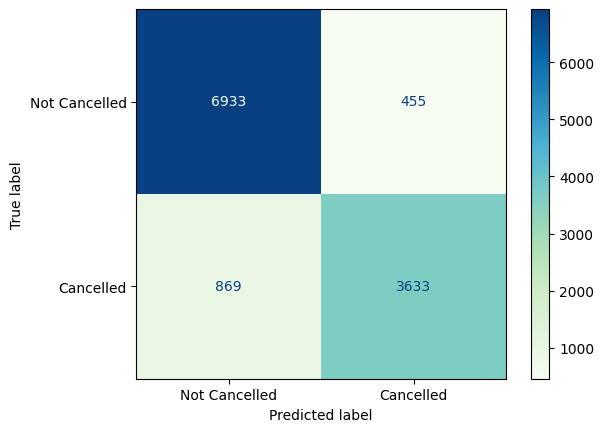

In [ ]:
# Confusion Matrix
pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test,labels = [0,1], display_labels = ['Not Cancelled', 'Cancelled'],
                     cmap= 'GnBu')

In [ ]:
# Threshold Tuning - Precision / Recall 

tc = 0.5 #set threshold value (sklearn defualt at 0.5)

print('Confusion Matrix:', confusion_matrix(y_test, pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('Accuracy Score:', accuracy_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('Precision Score:', precision_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('Recall Score:', recall_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('F1 Score:', f1_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

Confusion Matrix: [[6933  455]
 [ 869 3633]]
Accuracy Score: 0.888645920941968
Precision Score: 0.8886986301369864
Recall Score: 0.806974677920924
F1 Score: 0.8458672875436554


# Selecting the right metric

The right metric is the one that helps us optimize our business objectives. Let's revise our business objectives and how does the confusion matrix relate to it. 

### Business Objective: Maximize occupany while ensuring high customer satisfaction. 

The non-negotiable aspect of this objective is high customer satisfaction. Here's what that would mean for the confusion matrix:

## Confusion Matrix:

Let's consider the confusion matrix we have above


**True Negatives are 6985** - Predicted Not Cancelled, actually Not Cancelled. The Hotel doesn't need to take any action here. These bookings occupy the rooms and bring in the revenue. 

**True Positives are 3675** - Predicted cancelled, actually cancelled. These bookings are accurately predicted to cancel or not show up on the day of arrival. Since the model predicts these accurately, the hotel can take overbookings for these 3675 bookings. This ensures the rooms don't go vacant on the day, and the hotel also maximizes the profit by firstly - charging cancellations fees and secondly - filling those with new bookings. 

**False Negatives are 798** - Predicted Not Cancelled, actually cancelled. These are guests who we expected to show up, thus kept their booked rooms reserved. However since they didn't show up, it leads to rooms going vacant. Thus leading to potential revenue loss. We can't do anything about these in advance as our model is not able to predict them correctly. 

**False Positives are 432** - Predicted Cancelled, acutally not cancelled. These are guests we expected to cancel, but actually showed up. There is no way of knowing this in advance, so we might have already reassigned their rooms to newer bookings. This is definitely going to lead to bad customer satisfaction due caused due to inaccurate model predictions. 

## Precision - Recall Trade-Off

Now let's look at the business objective again. Since its non - negotiable to have undesired customer dis-satisfaction, we can't have a situation where we predict customers to cancel and they come and find a room unavailable. 

So its makes sense of focus on reducing these False Positives to ensure high customer satisfaction, which translates to a high Precision for our model. 

Now precision and recall always have a trade-off, so in an attempt to reduce False Positives we will increase False Negatives, which means we will end up predicting lots of guests to show up who end up cancelling. 

An increase in False Negatives is rooms being vacant, thus higher the FN the highes the revenue loss. This really is a dilemma. Let's see how to resolve this.

## Metric relevant to our Business Problem 


Let's closely observe FP and FN and see whats actually happening here. 
FP are basically customers who unexpectedly show up, needing rooms last moment. And FN are customers who unexpectedly cancel, leaving rooms unfilled last moment. 

What if we alocate the False Positives to the rooms that we had reserved for False Negatives? That would definitely help us optimize the bookings and not lose on potential revenue. 

In our current Confusion Matrix, our FP is 432 and FN is 798. This means we can accommodate those 432 last moment show ups in the reserved rooms of the 798 non-show ups. 

We have optimised our profits. But this still leaves 798-432 = 366 rooms unfilled. 

**For our business problem, it would be desirable to have a model that minimizes the difference between False Positives and False Negatives, while making sure False Negatives are higher than False positives.** We don't want customers showing up and all rooms being booked. 

We can tweak the difference between FP and FN by tuning the classification threshold value, which has a default of 0.5

We will find a threshold value that gives up the smallest possible positive value for (FN-FP).

Lets calculate FN-FP for the entire threshold range, and find out our desired threshold value!


In [ ]:
from tqdm import tqdm

thresholds = []
differences = []

# looping over 100 threshold values, all equally spaced between 0 and 1
for tc in tqdm(list(np.round(np.linspace(0,1,num = 100),2))):
    cm = confusion_matrix(y_test, pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0])
    fp = cm[0][1]
    fn = cm[1][0]
    diff = fn - fp
    thresholds.append(tc)
    differences.append(diff)

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


In [ ]:
# making a dataframe to be able to sort out the desired pair of (difference, threshold)
temp = pd.DataFrame()
temp['Difference'] = differences
temp['Threshold'] = thresholds
temp['x line'] = 0 #Just adding it here. Will come in handly for plotting the graph in the next section 

# Calculating the smallest positive difference and the corresponding Threshold value. 
min_idx = temp[temp.Difference > 0].Difference.idxmin()
temp.iloc[min_idx]

Difference    23.00
Threshold      0.43
x line         0.00
Name: 43, dtype: float64

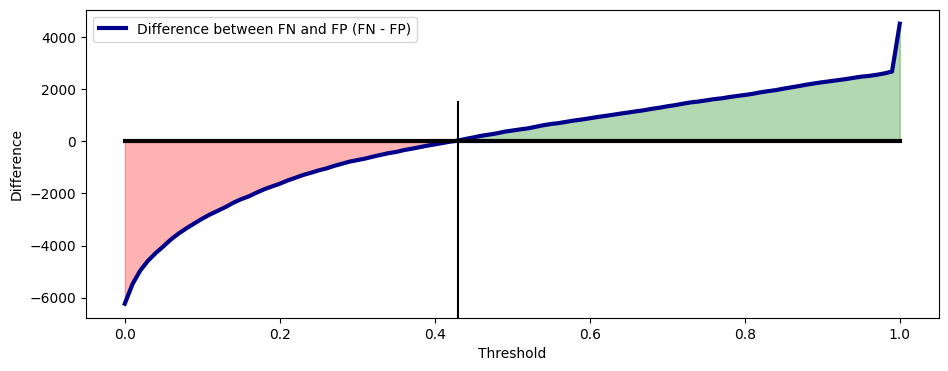

In [ ]:
#plt.xkcd()
#plt.rcdefaults()
#plt.style.use(plt.style.available[4])

plt.figure(figsize = (11,4))

ax1 = sns.lineplot(x = thresholds, y = differences, lw = 3, color = 'darkblue',
                   label = 'Difference between FN and FP (FN - FP)')
ax2 = sns.lineplot(x = thresholds, y = temp['x line'], lw = 3, color = 'k')
plt.axvline(x = 0.43,ymin = 0, ymax = 0.7, color = 'k')


plt.fill_between(temp['Threshold'],temp['Difference'],temp['x line'],
                 where = (temp['Difference'] > temp['x line']),color = 'green', interpolate = True, alpha = 0.3)

plt.fill_between(temp['Threshold'],temp['Difference'],temp['x line'],
                 where = (temp['Difference'] < temp['x line']),color = 'red', interpolate = True, alpha = 0.3)

plt.xlabel('Threshold')
plt.ylabel('Difference')

plt.show()

Based on our calculations and the graph above, the smalled positive value of (FN-FP) is 12. The corresponding threshold is 0.43. 

### Performance Scores with threshold = 0.43

In [ ]:
# Threshold Tuning - Precision / Recall 

tc = 0.43 #set threshold value (sklearn defualt at 0.5)

print('Accuracy Score:', accuracy_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('Precision Score:', precision_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('Recall Score:', recall_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

print('F1 Score:', f1_score(y_test,
                    pd.DataFrame(model.predict_proba(X_test)[:,1] > tc).astype(int)[0]))

Accuracy Score: 0.8872161480235492
Precision Score: 0.8528689439607056
Recall Score: 0.8485117725455353
F1 Score: 0.8506847789778421


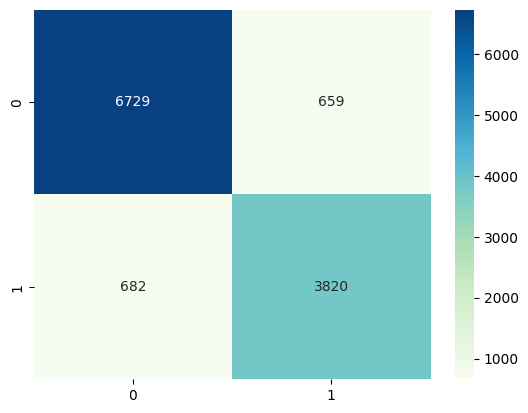

In [ ]:
sns.heatmap(confusion_matrix(y_test, pd.DataFrame(model.predict_proba(X_test)[:,1] > 0.43).astype(int)[0]),
           annot = True, cmap = 'GnBu', fmt = '.0f')

### Observations

1. Our Model overall accuracy is still at 89%, just like the the original Model accuracy.
2. Our Precision has reduced, and Recall has increased. Now both are at around 86%. But this works in favour of our business problem and the goal of filling all the rooms without compromising on customer satisfaction!
3. As seen in our updated confusion matrix - the FP and FN are extremely close to each other. FN - FP = 12, just like we calculated above. 

# 7. Feature Importance

In [ ]:
features_importance = pd.DataFrame(columns = ['Column Name','Importance'])

features_importance['Column Name'] = updated_data.drop(['hotel'],1).columns
features_importance['Importance'] = model.feature_importances_

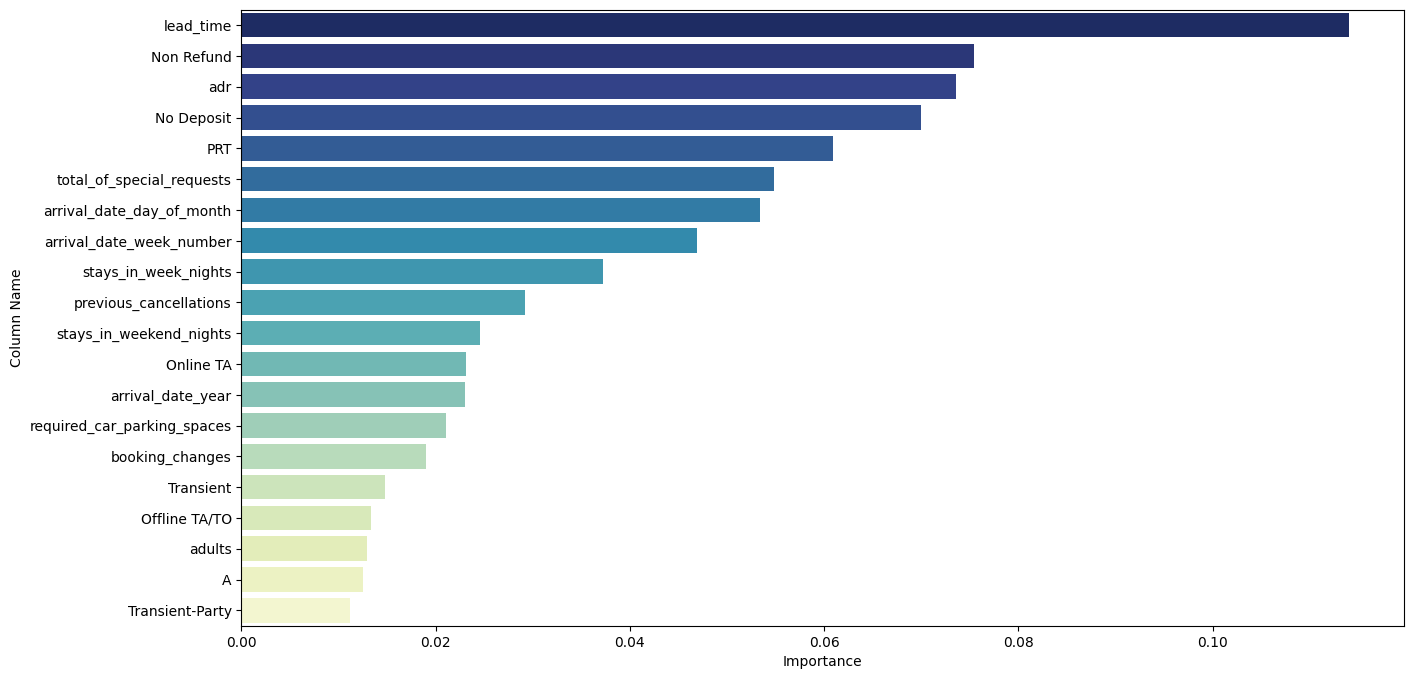

In [ ]:
plt.figure(figsize = (15,8))

sns.barplot(x = features_importance.sort_values(by = 'Importance', ascending = False)['Importance'][:20],
            y = features_importance.sort_values(by = 'Importance', ascending = False)['Column Name'][:20],
            palette = 'YlGnBu_r')